In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [4]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

print(avDev)

cuda


In [6]:
torch.manual_seed(1)
np.random.seed(1)

In [7]:
len(trainset)

50000

In [8]:
# STEP 2: MAKING DATASET ITERABLE
 
batch_size = 500
n_iters = 5000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
 
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=len(testset), 
                                          shuffle=False)
 

In [9]:
'''
STEP 3: CREATE MODEL CLASS
'''
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim, activation_fn):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, 3000)
        self.linear1_drop = nn.Dropout(0.2)
        self.linear2 = nn.Linear(3000, 3000)
        self.linear2_drop = nn.Dropout(0.2)
        self.linear3 = nn.Linear(3000, output_dim)
        self.activation_fn = activation_fn
     
    def forward(self, x):
        out = self.activation_fn(self.linear1(x))
        layer1_out = self.linear1_drop(out)
        out = self.activation_fn(self.linear2(layer1_out))
        layer2_out = self.linear2_drop(out)
        out = self.linear3(layer2_out)
        return out
    

In [10]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss().to(avDev)


In [11]:
def hinge_loss(outputs, labels):
    margins = np.maximum(0, outputs-labels +1)
    loss = np.sum(margins)
    return loss
    

In [12]:
# optimizers = [torch.optim.SGD, optimizer_Adam, optimizer_Adagrad, optimizer_Adadelta, optimizer_RMSprop]

optimizers = ['Adam','SGD','Adagrad', 'Adadelta', 'RMSprop']
activation_fns = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]

In [13]:
#L1, and L2 regularization parms

lambda1 = 0.001
lambda2 = 0.1

In [14]:
'''
STEP 7: TRAIN THE MODEL
'''
def train_model():
    for activation_fn in activation_fns:
        
        input_dim = 3*32*32
        output_dim = 10
        
        
        for opt in optimizers:
            
            print('Activation Function: {} Optimizer: {}'.format(activation_fn,opt))
            optimizer = None
            model = None
            model = LogisticRegressionModel(input_dim, output_dim, activation_fn)
            model.to(avDev)
                  
            if opt == 'SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
                
            elif opt == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
                
            elif opt == 'Adagrad':
                optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001)
                
            elif opt == 'Adadelta':
                optimizer = torch.optim.Adadelta(model.parameters(), lr=0.003)
                
            elif opt == 'RMSprop':
                optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000003)

            loss_save = np.empty(n_iters-1)
            iter = 0
            for epoch in range(num_epochs):
                for i, (images, labels) in enumerate(train_loader):

                    images = images.view(-1, 3*32*32).to(avDev)
                    labels = labels.to(avDev)

                    # Clear gradients w.r.t. parameters
                    optimizer.zero_grad()


                    # Forward pass to get output/logits
                    outputs = model(images)
            #         outputs = model(images)

                    # Calculate Loss: softmax --> cross entropy loss
                    cross_entropy_loss = criterion(outputs, labels)#


                    all_linear1_params = torch.cat([x.view(-1) for x in model.linear1.parameters()])
                    all_linear2_params = torch.cat([x.view(-1) for x in model.linear2.parameters()])
                    l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
                    l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)

                    loss = cross_entropy_loss
                    # loss = cross_entropy_loss + l1regularization + l2_regularization
                    loss = cross_entropy_loss + l2_regularization
                    # Getting gradients w.r.t. parameters
                    loss.backward()

                    # Updating parameters
                    optimizer.step()

                    #Save Loss    

                    loss_save[iter-1] = loss.item()
                    iter += 1

                    if iter % 200 == 0:
                        # Calculate Accuracy         
                        correct = 0
                        total = 0
                        # Iterate through test dataset
                        for images, labels in test_loader:
                            #######################
                            #  USE GPU FOR MODEL  #
                            #######################
                            images = images.view(-1, 3*32*32).to(avDev)

                            # Forward pass only to get logits/output
                            outputs = model(images)

                            # Get predictions from the maximum value
                            _, predicted = torch.max(outputs.data, 1)

                            # Total number of labels
                            total += labels.size(0)

                            #######################
                            #  USE GPU FOR MODEL  #
                            #######################
                            # Total correct predictions
                            correct += (predicted.cpu() == labels.cpu()).sum().float()

                        accuracy = 100. * correct / total

                        # Print Loss
                        print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
        

In [15]:
train_model()

Activation Function: ReLU(). Optimizer: Adam
Iteration: 200. Loss: 3.0904364585876465. Accuracy: 38.20000076293945
Iteration: 400. Loss: 2.364287853240967. Accuracy: 43.45000076293945
Iteration: 600. Loss: 1.9146909713745117. Accuracy: 44.56999969482422
Iteration: 800. Loss: 1.7877873182296753. Accuracy: 43.619998931884766
Iteration: 1000. Loss: 1.6616512537002563. Accuracy: 45.68000030517578
Iteration: 1200. Loss: 1.6649070978164673. Accuracy: 44.72999954223633
Iteration: 1400. Loss: 1.7202829122543335. Accuracy: 47.220001220703125
Iteration: 1600. Loss: 1.5737030506134033. Accuracy: 47.38999938964844
Iteration: 1800. Loss: 1.6662877798080444. Accuracy: 47.29999923706055
Iteration: 2000. Loss: 1.634154200553894. Accuracy: 48.86000061035156
Iteration: 2200. Loss: 1.5110828876495361. Accuracy: 49.15999984741211
Iteration: 2400. Loss: 1.6156537532806396. Accuracy: 49.04999923706055
Iteration: 2600. Loss: 1.4912859201431274. Accuracy: 48.58000183105469
Iteration: 2800. Loss: 1.50369191169

Iteration: 3000. Loss: 3.883531093597412. Accuracy: 41.349998474121094
Iteration: 3200. Loss: 3.8256678581237793. Accuracy: 41.939998626708984
Iteration: 3400. Loss: 3.789361000061035. Accuracy: 42.150001525878906
Iteration: 3600. Loss: 3.7070956230163574. Accuracy: 42.7599983215332
Iteration: 3800. Loss: 3.680737018585205. Accuracy: 43.08000183105469
Iteration: 4000. Loss: 3.6025004386901855. Accuracy: 43.060001373291016
Iteration: 4200. Loss: 3.5507869720458984. Accuracy: 43.599998474121094
Iteration: 4400. Loss: 3.501246452331543. Accuracy: 43.779998779296875
Iteration: 4600. Loss: 3.444969654083252. Accuracy: 43.7599983215332
Iteration: 4800. Loss: 3.478276252746582. Accuracy: 44.33000183105469
Iteration: 5000. Loss: 3.422091007232666. Accuracy: 44.54999923706055
Activation Function: Tanh(). Optimizer: Adam
Iteration: 200. Loss: 3.8775060176849365. Accuracy: 38.86000061035156
Iteration: 400. Loss: 2.8859143257141113. Accuracy: 39.59000015258789
Iteration: 600. Loss: 2.1559154987335

Iteration: 800. Loss: 4.784521579742432. Accuracy: 36.650001525878906
Iteration: 1000. Loss: 4.679326057434082. Accuracy: 37.0099983215332
Iteration: 1200. Loss: 4.632956504821777. Accuracy: 37.709999084472656
Iteration: 1400. Loss: 4.6508612632751465. Accuracy: 38.06999969482422
Iteration: 1600. Loss: 4.546135902404785. Accuracy: 38.459999084472656
Iteration: 1800. Loss: 4.4731645584106445. Accuracy: 38.599998474121094
Iteration: 2000. Loss: 4.373909950256348. Accuracy: 38.81999969482422
Iteration: 2200. Loss: 4.322139739990234. Accuracy: 39.279998779296875
Iteration: 2400. Loss: 4.309349536895752. Accuracy: 39.529998779296875
Iteration: 2600. Loss: 4.1949849128723145. Accuracy: 39.880001068115234
Iteration: 2800. Loss: 4.135806560516357. Accuracy: 39.959999084472656
Iteration: 3000. Loss: 4.082680702209473. Accuracy: 39.61000061035156
Iteration: 3200. Loss: 3.9785869121551514. Accuracy: 40.119998931884766
Iteration: 3400. Loss: 3.9457786083221436. Accuracy: 39.81999969482422
Iteratio

Iteration: 3600. Loss: 5.354618072509766. Accuracy: 12.079999923706055
Iteration: 3800. Loss: 5.357110977172852. Accuracy: 11.369999885559082
Iteration: 4000. Loss: 5.345876693725586. Accuracy: 12.149999618530273
Iteration: 4200. Loss: 5.339518070220947. Accuracy: 12.069999694824219
Iteration: 4400. Loss: 5.322750568389893. Accuracy: 11.449999809265137
Iteration: 4600. Loss: 5.31834077835083. Accuracy: 12.350000381469727
Iteration: 4800. Loss: 5.315279006958008. Accuracy: 11.90999984741211
Iteration: 5000. Loss: 5.296778202056885. Accuracy: 11.850000381469727
Activation Function: Sigmoid(). Optimizer: RMSprop
Iteration: 200. Loss: 5.332097053527832. Accuracy: 14.260000228881836
Iteration: 400. Loss: 5.224196910858154. Accuracy: 16.889999389648438
Iteration: 600. Loss: 5.129657745361328. Accuracy: 19.200000762939453
Iteration: 800. Loss: 5.009190559387207. Accuracy: 21.530000686645508
Iteration: 1000. Loss: 4.907609939575195. Accuracy: 22.93000030517578
Iteration: 1200. Loss: 4.79990863

# Best Combinations:
    Number of layers: 3
    Activatoin Function: ReLU
    Optimizer : Adam
    Regularizations: Dropout + L2

In [23]:
#Train with best combination of parameters 

input_dim = 3*32*32
output_dim = 10

optimizer = None
model = None
model = LogisticRegressionModel(input_dim, output_dim, nn.ReLU())
model.to(avDev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_save = np.empty(n_iters-1)
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()


        # Forward pass to get output/logits
        outputs = model(images)
#         outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        cross_entropy_loss = criterion(outputs, labels)#


        all_linear1_params = torch.cat([x.view(-1) for x in model.linear1.parameters()])
        all_linear2_params = torch.cat([x.view(-1) for x in model.linear2.parameters()])
        l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
        l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)

        loss = cross_entropy_loss
        # loss = cross_entropy_loss + l1regularization + l2_regularization
        loss = cross_entropy_loss + l2_regularization
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        #Save Loss    

        loss_save[iter-1] = loss.item()
        iter += 1

In [18]:
correct = 0
total = 0
model.to(avDev)

with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  train images: %d %%' % (100 * correct / total))

Accuracy of the network on the  train images: 58 %


In [19]:
print(images.size())

torch.Size([500, 3072])


In [20]:
outputs.size()

torch.Size([500, 10])

In [21]:
labels.size()

torch.Size([500])

# Learning Curve

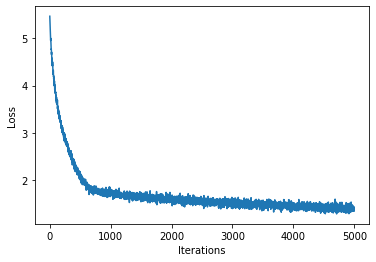

In [24]:
ax = sns.lineplot(data = loss_save)
ax.set(xlabel = "Iterations", ylabel="Loss")
plt.show()

# Confusion Matrix

In [25]:
model.to(avDev)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
cm = confusion_matrix(predicted.cpu(), labels.cpu()).astype(np.int)

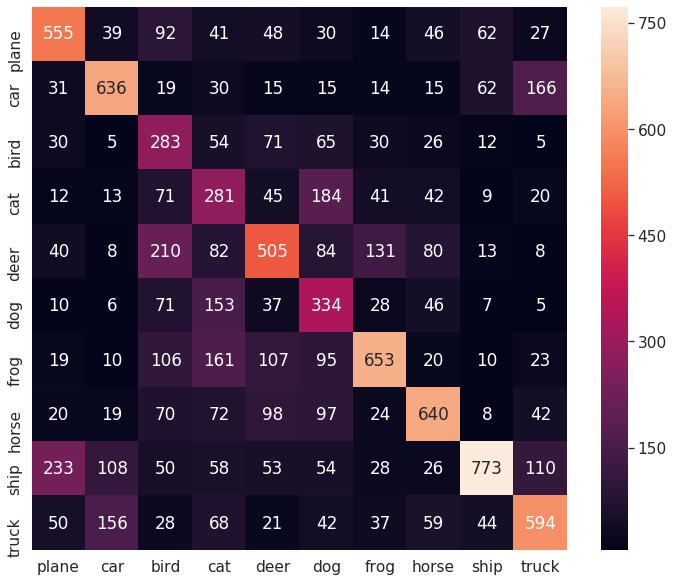

In [26]:
import pandas as pd
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(12,10))
df_cm = pd.DataFrame(cm,CLASSES,CLASSES)
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm,annot=True,fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [34]:
def hinge_loss(outputs):
    _, predicted = torch.max(outputs.data, 1)
    output_label = outputs[predicted]
    margins = np.maximum(0, outputs.cpu().detach().numpy()-output_label.cpu().numpy() +1)
    loss = np.sum(margins)
    return loss
    

In [48]:
def softmax_loss(outputs):
    _, predicted = torch.max(outputs.data, 1)
    output_label = outputs[predicted].cpu()
    output_label_exp = np.exp(outputs.cpu().numpy())
    sum_output_label_exp = np.sum(output_label_exp, axis = 0)
    normalized_output_labels = output_label_exp / sum_output_label_exp
    loss = -np.log(normalized_output_labels)
    return loss

In [ ]:
correct = 0
total = 0
model.to(avDev)

with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss1 = hinge_loss(outputs)
        loss2 = softmax_loss(outputs)
        print(loss1)
        print(loss2)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
